# Replication file for 'The Intertemporal Keynesian Cross'
### Part I: IKC environment, calibration and iMPCs (sections 3 and 4)

Adrien Auclert, Matthew Rognlie, Ludwig Straub

April 2024

In [1]:
import numpy as np
from scipy import optimize
import pandas as pd
import json

In [2]:
import jacobian_manipulation as jac
from calibration import get_calibration_ikc, get_ha_calibrations
import sec34_plots as plots

opts = {'texfig': True, 'savefig': True}    # flags for plotting

# iMPC data
Load Fagereng et al (2021) income-weighted iMPC data (from spreadsheet provided directly by authors) and lower bound from Italian SHIW (computed in `appendix_shiw.ipynb`):

In [3]:
df = pd.read_csv('data/FIG2_c1R_inc_weight.csv', header=None)
impc_data = df[0].values[4:]   # rows 0-3 are pre-periods, impcs start at 4
impc_sd = df[1].values[4:]
impc_lb_italy = np.loadtxt('impc_lb_italy.txt')

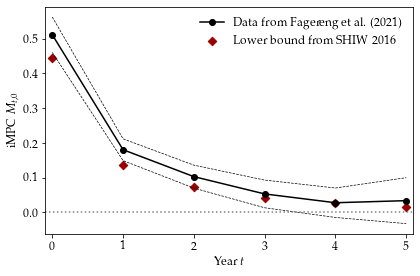

In [4]:
plots.figure1(impc_data, impc_sd, impc_lb_italy, **opts) 

# Calibrating heterogeneous-agent models

In [5]:
calib = get_calibration_ikc()                       # general IKC parameters
calib_ha_one, calib_ha_two = get_ha_calibrations()  # HA-specific parameters

## One-asset HA models

In [6]:
from models_heterogeneous import ha_one
params, hh_het, ss_het = {}, {}, {}

In [7]:
def get_ss_impc_one(beta, Z):
    ss = ha_one.steady_state({**calib, **calib_ha_one, 'beta': beta, 'Z': Z})
    impc = ha_one.impulse_linear(ss, inputs={'Z': 1.*(np.arange(5)==0)})['C']
    return ss, impc

We will calibrate $\beta$ in two different ways.

First, HA-hi-liq calibrates such that assets match our target for government bonds:

In [8]:
beta = optimize.brentq(lambda beta: get_ss_impc_one(beta, calib['Z'])[0]['A'] - calib['B'], 0.6, 0.94)
ss, impc = get_ss_impc_one(beta, calib['Z'])
beta, ss['A']/ss['Z'], impc[0]

(0.9386249724338022, 6.287814520540989, 0.09829845478672866)

In [9]:
params['HA-hi-liq'], hh_het['HA-hi-liq'], ss_het['HA-hi-liq'] = {'beta': beta, 'Z': calib['Z']}, ha_one, ss

Next, HA-one calibrates $\beta$ such that the first iMPC matches the data.

This requires abandoning our target for assets, which equal government bonds in equilibrium. The lower level of bonds that results leads to a higher level of post-tax income $Z$, which affects the household steady state. We thus need to solve for $\beta$ and $Z$ simultaneously.

(Note: in theory iMPCs should actually be invariant to the scale of $Z$, but there can be slight differences numerically unless we rescale the asset grid. For consistency, we do not impose scale invariance here.)

In [10]:
Y, G, r = calib['Y'], calib['G'], calib['r']
def resid_ha_one(x):
    """Solve for beta and Z that match impc and Y = r*A + G + Z"""
    beta, Z = x
    ss, impc = get_ss_impc_one(beta, Z)
    return np.array([impc[0] - impc_data[0], Y - r*ss['A'] - G - Z])

beta, Z_ha_one = optimize.fsolve(resid_ha_one, [0.93, calib['Z']])
ss, impc = get_ss_impc_one(beta, Z_ha_one)
beta, ss['A']/ss['Z'], impc[0]

(0.8654697058832176, 0.20937729297320293, 0.5111663349999059)

In [11]:
params['HA-one'], hh_het['HA-one'], ss_het['HA-one'] = {'beta': beta, 'Z': Z_ha_one}, ha_one, ss

#### Plotting Figure D.2ab: policy functions

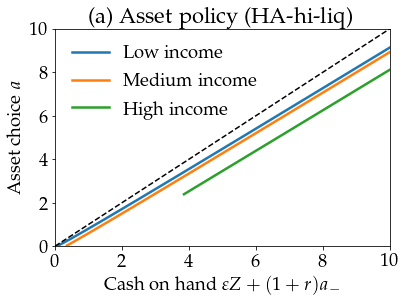

In [12]:
plots.figureD2ab(ss_het['HA-hi-liq'], '(a) Asset policy (HA-hi-liq)', 'hi_liq', **opts)

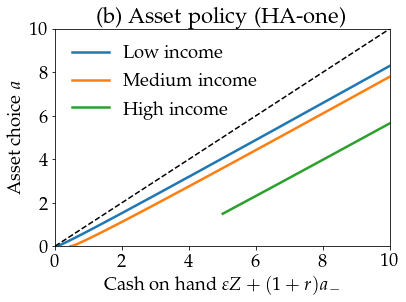

In [13]:
plots.figureD2ab(ss_het['HA-one'], '(b) Asset policy (HA-one)', 'one', **opts)

#### Plotting Figure D2c: distributions

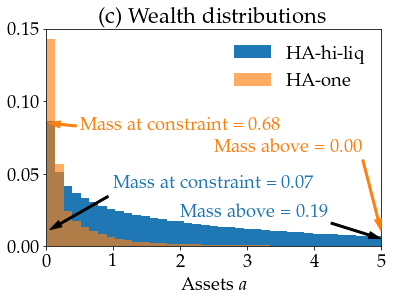

In [14]:
plots.figureD2c(ss_het, **opts)

## Two-asset HA model

This is significantly more time-consuming than the previous calibrations, both because it involves a trickier multi-dimensional problem and because the two-asset code takes longer to run.

The goal is to find $\nu$ and $\beta$ such that we hit the first iMPC and also the asset target. First, like before, set up a simple helper function that returns this information.

In [15]:
from models_heterogeneous import ha_two
def get_ss_impc_two(beta, nu):
    ss = ha_two.steady_state({**calib, **calib_ha_two, 'beta': beta, 'nu': nu})
    impc = ha_two.impulse_linear(ss, inputs={'Z': 1.*(np.arange(5)==0)})['C']
    return ss, impc

In [16]:
def resid_ha_two(x):
    """Solve for beta and nu that match impc and A = B"""
    beta, nu = x
    ss, impc = get_ss_impc_two(beta, nu)
    return np.array([impc[0] - impc_data[0], ss['A'] - calib['B']])

In [17]:
beta0, nu = optimize.fsolve(resid_ha_two, [0.93, 0.089])
# extra run to hit asset market clearing exactly
beta = optimize.brentq(lambda beta: get_ss_impc_two(beta, nu)[0]['A'] - calib['B'], beta0-1E-8, beta0+1E-8)

# uncomment this and comment out above to skip solving for beta and nu
# beta, nu = 0.9309259084629996, 0.08909190912437809

In [18]:
ss, impc = get_ss_impc_two(beta, nu)
beta, nu, ss['A']/ss['Z'], impc[0]

(0.9309259084629765,
 0.08909190912433046,
 6.287814520452134,
 0.5111663349998634)

In [19]:
params['HA-two'], hh_het['HA-two'], ss_het['HA-two'] = {'beta': beta, 'nu': nu, 'Z': calib['Z']}, ha_two, ss

#### Plot Figure D.3

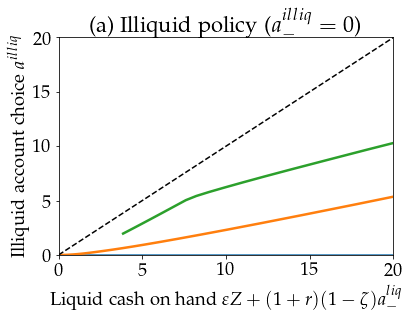

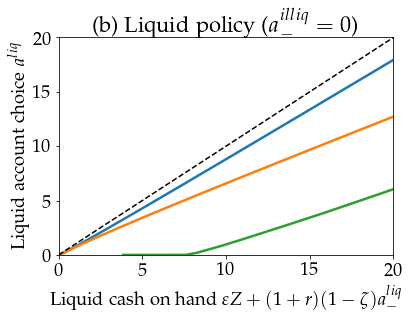

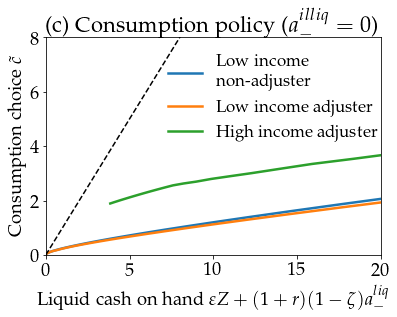

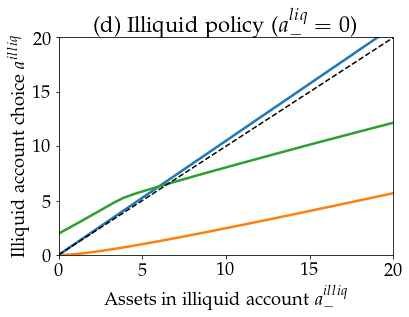

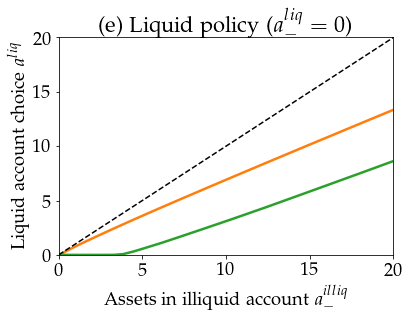

In [20]:
plots.figureD3ae(ss_het['HA-two'], **opts)

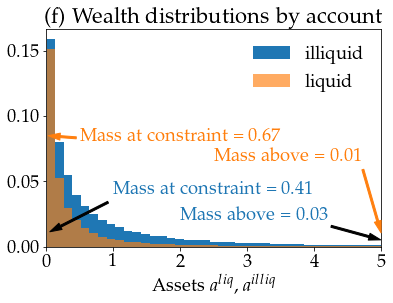

In [21]:
plots.figureD3f(ss_het['HA-two'], **opts)

#### Table D.1: Distributional statistics for all heterogeneous-agent models

In [22]:
plots.tableD1(ss_het).round(2)

,HA-hi-liq,HA-one,HA-two
Share of HtM (aliq = 0),0.04,0.58,0.58
Share with liquid assets aliq <= 0.1,0.14,0.80,0.78
"Share of WHtM (aliq = 0, ailliq>0)",NaN,NaN,0.28
Share of income to HtM,0.01,0.30,0.36
Share of income to aliq <= 0.1,0.05,0.57,0.61
Share of income to WHtM,NaN,NaN,0.22
Gini coefficient,0.60,0.90,0.94
Top 10pc share,0.40,0.83,0.89
Post-tax income,0.47,0.61,0.47


#### Computing M and A matrices for heterogeneous-agent models
Now that we've calibrated the heterogeneous-agent models, we'll compute their M and A matrices, which we'll need for later.

In [23]:
Ms, As = {}, {}
T = 80 # won't need more than this
for m in ss_het:
    J = hh_het[m].jacobian(ss_het[m], inputs=['Z'], outputs=['C', 'A'], T=T)
    Ms[m], As[m] = J['C', 'Z'], J['A', 'Z']

# Calibration of analytical models

We will now go through each of the five analytical models (RA, TA, BU, TABU, ZL) and calibrate parameters, to the extent possible, to fit iMPCs, and then obtain the full T-by-T M matrices for the calibrated versions.

In [24]:
from models_analytical import MA_RA, MA_TA, MA_BU, MA_TABU, MA_ZL
r = calib['r']

#### RA model
For the RA model, there is nothing to calibrate: the steady-state $r$, fixed across all our models, pins down $\beta=1/(1+r)$ and thus the Jacobians.

In [25]:
Ms['RA'], As['RA'] = MA_RA(r, T)
params['RA'] = {}

#### TA model
For the TA model, we can choose $\mu$ so that $M_{00}^{TA} \equiv \mu + (1-\mu)M_{00}^{RA}$ equals our data $M_{00}^{data}$. Solving, we see that
$$
\mu = \frac{M_{00}^{data} - M_{00}^{RA}}{1-M_{00}^{RA}}
$$

In [26]:
mu = (impc_data[0] - Ms['RA'][0,0])/(1-Ms['RA'][0,0])
params['TA'] = {'mu': mu}
Ms['TA'], As['TA'] = MA_TA(r, mu, T)
mu

0.48672465174999996

#### BU model
For the BU model, we need to set $M_{00}^{BU} \equiv m = 1 - \frac{\lambda}{1+r}$ equal to $M_{00}^{data}$. It follows that
$$
\lambda = (1+r)(1 - M_{00}^{data})
$$
We also have a somewhat arbitrary choice of $\beta$ to make. In our parametrization of the BU $\mathbf{M}$ matrix, $\beta$ only affects anticipatory behavior, and not $M_{\cdot,0}$. which is where we have data. For consistency with the similarly-behaved HA-one model, we'll choose our $\beta$ to match it.

In [27]:
lamb = (1+r)*(1-impc_data[0])
beta = ss_het['HA-one']['beta']
params['BU'] = {'beta': beta, 'lamb': lamb}
Ms['BU'], As['BU'] = MA_BU(beta, r, lamb, T)
lamb

0.5132753482500001

#### TABU model
Now, we have two free parameters, $\mu$ and $\lambda$, which map to the first two iMPCs by:
$$
\begin{align}
M_{00}^{TABU} &= \mu + (1-\mu)(1-\frac{\lambda}{1+r}) \\
M_{10}^{TABU} &= (1-\mu)\lambda(1-\frac{\lambda}{1+r})
\end{align}
$$
We calibrate them to match the first two iMPCs that we obtained for the HA-one model:

In [28]:
def resid_tabu(x):
    mu, lamb = x
    m = 1 - lamb/(1+r)
    return Ms['HA-one'][:2,0] - np.array([mu+(1-mu)*m, (1-mu)*lamb*m])
mu, lamb = optimize.fsolve(resid_tabu, [0.5, 0.5])
params['TABU'] = {'beta': beta, 'mu': mu, 'lamb': lamb}
Ms['TABU'], As['TABU'] = MA_TABU(beta, r, lamb, mu, T)

#### ZL model
The ZL model has the same parameters as the TABU model and the same mapping of these parameters to the first column of iMPCs (although subtle differences afterward). We therefore use exactly the same calibration.

In [29]:
params['ZL'] = {'beta': beta, 'mu': mu, 'lamb': lamb}
Ms['ZL'], As['ZL'] = MA_ZL(beta, r, lamb, mu, T)

## Table 2: completed calibration

In [30]:
df = plots.table2(params, ss_het, calib, calib_ha_one, calib_ha_two)
df

,RA,HA-hi-liq,TA,BU,TABU,ZL,HA-one,HA-two
eis,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
r,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05
A/Z,6.29,6.29,6.29,6.29,6.29,0.0,0.21,6.29
beta,0.95,0.94,0.95,0.87,0.87,0.87,0.87,0.93
mu,0.0,0.01,0.49,0.0,0.29,0.29,0.3,0.36
lambda,,,,0.51,0.72,0.72,,
m,,,,0.51,0.31,0.31,,
rho_e,,0.91,,,,,0.91,0.91
sd_e,,0.92,,,,,0.92,0.92
theta,,0.181,,,,,0.181,0.181


# iMPCs in data vs. models

#### Figure 2
Plot the M matrices against the data:

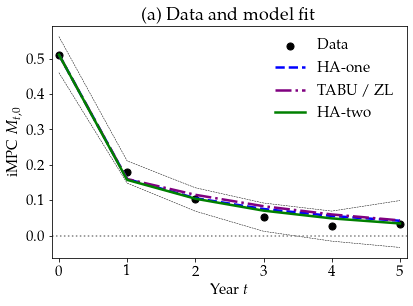

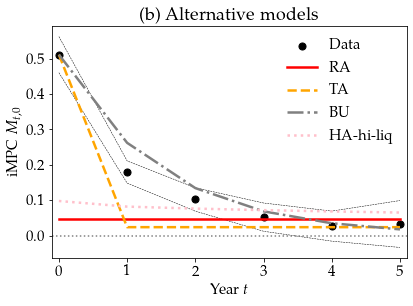

In [31]:
plots.figure2(impc_data, impc_sd, Ms, **opts)

#### Figure 3

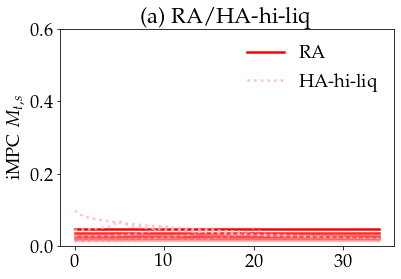

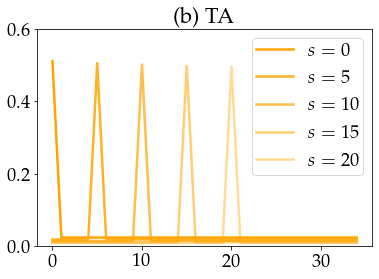

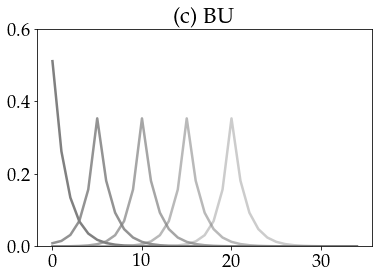

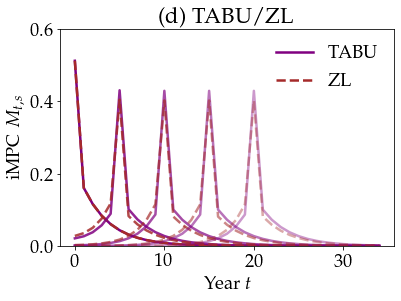

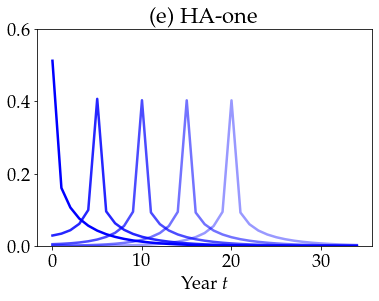

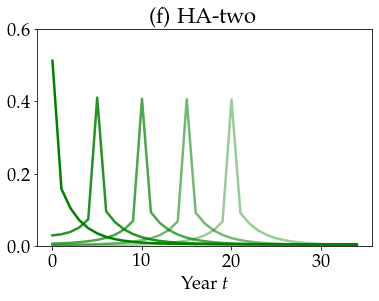

In [32]:
plots.figure3_and_D1(Ms, Mflag=True, **opts)

#### Figure D.1
Essentially the same as the previous figure, just with asset Jacobians.

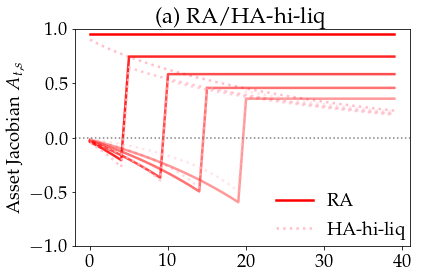

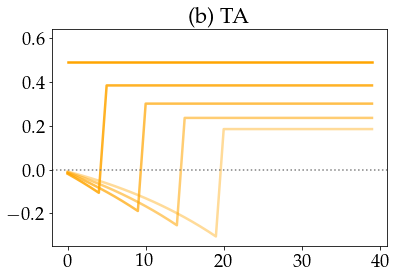

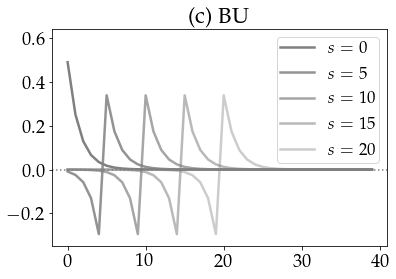

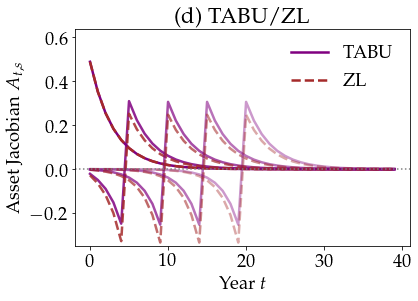

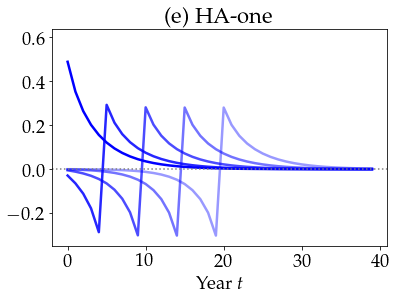

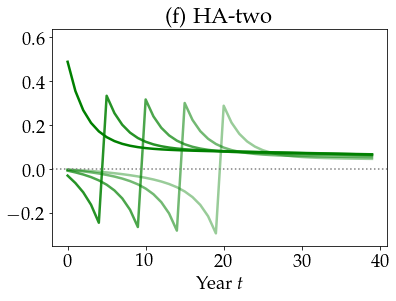

In [33]:
plots.figure3_and_D1(As, Mflag=False, **opts)

#### Figure 4

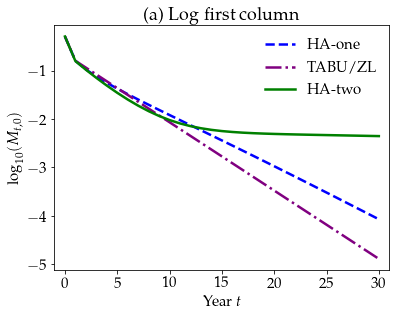

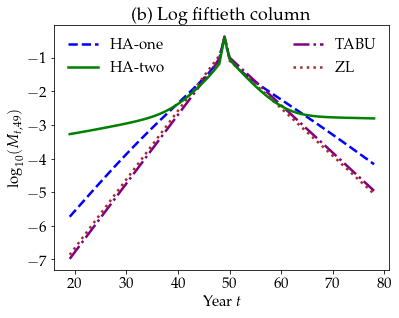

In [34]:
plots.figure4(Ms, **opts)

## Save parameters so that calibration can easily be recreated

In [35]:
with open('solved_params.json', "w") as json_file:
    json.dump(params, json_file, indent=4)